In [1]:
%matplotlib inline
from nuscenes.nuscenes import NuScenes

nusc = NuScenes(version='v1.0-trainval', dataroot='/home/mike/workspaces/ECE579/data', verbose=True)

Loading NuScenes tables for version v1.0-trainval ...
23 category,
8 attribute,
4 visibility,
64386 instance,
12 sensor,
10200 calibrated_sensor,
2631083 ego_pose,
68 log,
850 scene,
34149 sample,
2631083 sample_data,
1166187 sample_annotation,
4 map,
Done loading in 27.1 seconds.
Reverse indexing ...
Done reverse indexing in 6.7 seconds.


In [2]:
my_scene = nusc.scene[0]
first_sample_token = my_scene['first_sample_token']
my_sample = nusc.get('sample', first_sample_token)
my_sample

{'token': 'e93e98b63d3b40209056d129dc53ceee',
 'timestamp': 1531883530449377,
 'prev': '',
 'next': '14d5adfe50bb4445bc3aa5fe607691a8',
 'scene_token': '73030fb67d3c46cfb5e590168088ae39',
 'data': {'RADAR_FRONT': 'bddd80ae33ec4e32b27fdb3c1160a30e',
  'RADAR_FRONT_LEFT': '1a08aec0958e42ebb37d26612a2cfc57',
  'RADAR_FRONT_RIGHT': '282fa8d7a3f34b68b56fb1e22e697668',
  'RADAR_BACK_LEFT': '05fc4678025246f3adf8e9b8a0a0b13b',
  'RADAR_BACK_RIGHT': '31b8099fb1c44c6381c3c71b335750bb',
  'LIDAR_TOP': '3388933b59444c5db71fade0bbfef470',
  'CAM_FRONT': '020d7b4f858147558106c504f7f31bef',
  'CAM_FRONT_RIGHT': '16d39ff22a8545b0a4ee3236a0fe1c20',
  'CAM_BACK_RIGHT': 'ec7096278e484c9ebe6894a2ad5682e9',
  'CAM_BACK': 'aab35aeccbda42de82b2ff5c278a0d48',
  'CAM_BACK_LEFT': '86e6806d626b4711a6d0f5015b090116',
  'CAM_FRONT_LEFT': '24332e9c554a406f880430f17771b608'},
 'anns': ['173a50411564442ab195e132472fde71',
  '5123ed5e450948ac8dc381772f2ae29a',
  'acce0b7220754600b700257a1de1573d',
  '8d7cb5e96cae48c39

In [3]:
my_firstannotationToken = my_sample['anns'][3]
my_firstannotationToken
nusc.get('sample_annotation',my_firstannotationToken)

{'token': '8d7cb5e96cae48c39ef4f9f75182013a',
 'sample_token': 'e93e98b63d3b40209056d129dc53ceee',
 'instance_token': 'f7c451dfcd2a4587b3af322d081dddad',
 'visibility_token': '4',
 'attribute_tokens': ['cb5118da1ab342aa947717dc53544259'],
 'translation': [1018.705, 605.045, 0.731],
 'size': [1.638, 4.25, 1.44],
 'rotation': [0.9930201651831624, 0.0, 0.0, 0.11794469695414371],
 'prev': '',
 'next': '3b3734f6209a4317bb8734bcc1e6305f',
 'num_lidar_pts': 150,
 'num_radar_pts': 2,
 'category_name': 'vehicle.car'}

In [4]:
FrontRadarData = nusc.get('sample_data', my_sample['data']['RADAR_FRONT'])
FrontLeftRadarData = nusc.get('sample_data', my_sample['data']['RADAR_FRONT_LEFT'])

#SHORT CUT 
#channel = nusc.sample_data[0]['channel']
FrontRadarData

#REDO THIS FOR EACH RADAR

{'token': 'bddd80ae33ec4e32b27fdb3c1160a30e',
 'sample_token': 'e93e98b63d3b40209056d129dc53ceee',
 'ego_pose_token': 'bddd80ae33ec4e32b27fdb3c1160a30e',
 'calibrated_sensor_token': '7781065816974801afc4dcdaf6acf92c',
 'timestamp': 1531883530440378,
 'fileformat': 'pcd',
 'is_key_frame': True,
 'height': 0,
 'width': 0,
 'filename': 'samples/RADAR_FRONT/n015-2018-07-18-11-07-57+0800__RADAR_FRONT__1531883530440378.pcd',
 'prev': '',
 'next': '90df03ad4710427aabb5f88fe049df2e',
 'sensor_modality': 'radar',
 'channel': 'RADAR_FRONT'}

In [5]:
FrontLeftRadarData

{'token': '1a08aec0958e42ebb37d26612a2cfc57',
 'sample_token': 'e93e98b63d3b40209056d129dc53ceee',
 'ego_pose_token': '1a08aec0958e42ebb37d26612a2cfc57',
 'calibrated_sensor_token': '825567807e4648fe974e8fc78afe968a',
 'timestamp': 1531883530486381,
 'fileformat': 'pcd',
 'is_key_frame': True,
 'height': 0,
 'width': 0,
 'filename': 'samples/RADAR_FRONT_LEFT/n015-2018-07-18-11-07-57+0800__RADAR_FRONT_LEFT__1531883530486381.pcd',
 'prev': '',
 'next': '839c8da6560342968d29771339a399e0',
 'sensor_modality': 'radar',
 'channel': 'RADAR_FRONT_LEFT'}

In [6]:
nusc.get('ego_pose',FrontLeftRadarData['ego_pose_token'])

{'token': '1a08aec0958e42ebb37d26612a2cfc57',
 'timestamp': 1531883530486381,
 'rotation': [-0.7460758580227835,
  -0.007683097562986563,
  0.008360747339989849,
  -0.6657641339027826],
 'translation': [1010.1545634465576, 610.9705097462538, 0.0]}

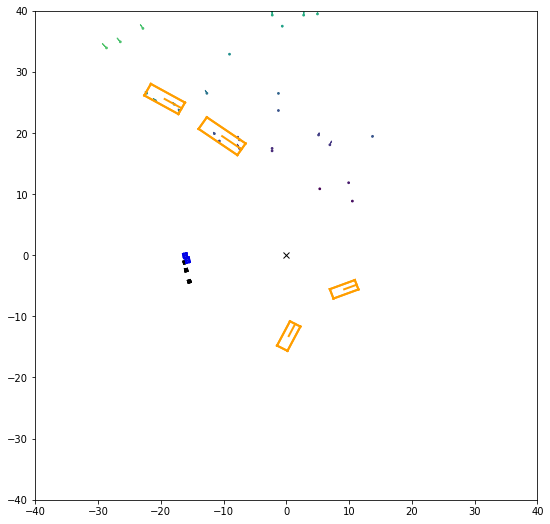

In [7]:
nusc.my_check_radar_intersects_with_box(my_sample['data']['RADAR_FRONT'], nsweeps=1)

In [9]:
_, boxes, _ = nusc.get_sample_data(FrontRadarData['token'])

In [10]:
boxes

[label: nan, score: nan, xyz: [-3.65, 16.20, 0.23], wlh: [0.30, 0.29, 0.73], rot axis: [-0.01, -0.01, -1.00], ang(degrees): -101.90, ang(rad): -1.78, vel: nan, nan, nan, name: movable_object.trafficcone, token: 173a50411564442ab195e132472fde71,
 label: nan, score: nan, xyz: [-6.77, 15.46, 0.24], wlh: [0.32, 0.34, 0.71], rot axis: [-0.01, -0.01, -1.00], ang(degrees): -107.89, ang(rad): -1.88, vel: nan, nan, nan, name: movable_object.trafficcone, token: 5123ed5e450948ac8dc381772f2ae29a,
 label: nan, score: nan, xyz: [17.01, 10.26, 0.97], wlh: [2.31, 7.52, 3.09], rot axis: [0.01, -0.01, 1.00], ang(degrees): -124.69, ang(rad): -2.18, vel: nan, nan, nan, name: vehicle.truck, token: acce0b7220754600b700257a1de1573d,
 label: nan, score: nan, xyz: [-8.02, -9.21, 0.34], wlh: [1.64, 4.25, 1.44], rot axis: [0.01, -0.02, 1.00], ang(degrees): -69.40, ang(rad): -1.21, vel: nan, nan, nan, name: vehicle.car, token: 8d7cb5e96cae48c39ef4f9f75182013a,
 label: nan, score: nan, xyz: [-3.28, 15.74, 0.76], w